In [1]:
import sys
sys.path.append('../')

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

from rcgp.experimental import SpatioTemporalRCGP
from rcgp.kernels import Matern32Kernel

In [2]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(42)  # For reproducibility

    x = tc.linspace(0, 1, 100)  # Same points for training and testing
    # Define known kernel parameters
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x))
    mean = tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)

    y = true_f + noise

    return x, y, true_f

def add_outliers(y):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    outliers_loc = [50, 51, 53, 54, 57, 59, 65]
    outliers_loc = [50, 51, 53, 54, 55, 56, 57, 59, 65]

    noise = tc.distributions.Normal(loc=0, scale=20.).sample((len(outliers_loc), ))
    y_outliers[outliers_loc] = y_outliers[outliers_loc] + noise
    return y_outliers, outliers_loc

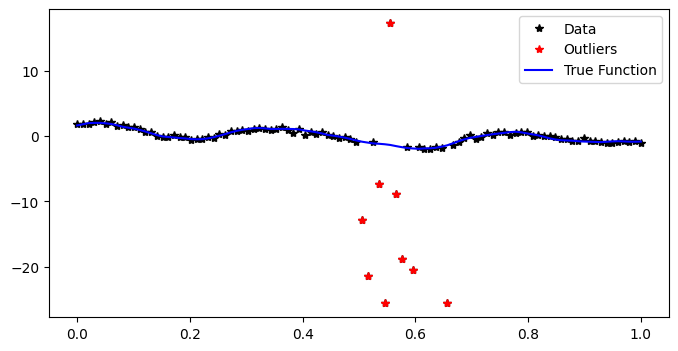

In [3]:
true_lengthscale=0.2
true_magnitude = 2.
true_var_y = 0.25
Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
Ys_outliers, outliers_loc = add_outliers(Ys)

plt.figure(figsize=(8,4))
plt.plot(Xs, Ys_outliers, 'k*', label="Data")
plt.plot(Xs[outliers_loc], Ys_outliers[outliers_loc], 'r*', label='Outliers')
plt.plot(Xs, true_func, 'b-', label="True Function")
plt.legend()

In [4]:
def fit(Xs, Ys, grid = None, activate_robustness = True, weighted_loss = True, c = 1., c_fixed=True, lr=0.2, n_steps=60, verbose=False):

    strcgp = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys.reshape(-1,1), p=1)

    if activate_robustness: strcgp.activate_robustness(func="m_pred")
    strcgp.c = c

    if c_fixed:
        strcgp.fixed_c()
    else:
        strcgp.adaptive_c()

    optimizer = tc.optim.Adam(strcgp.parameters(), lr=lr)

    if verbose:
        print("---------INIT------------")
        with tc.no_grad():
            energies, _ = strcgp.forward(optim=True)
            loss = energies.sum()
            print("Loss : {}".format(loss.detach().clone()))

            for name, param in strcgp.named_parameters():
                
                if param.requires_grad:
                    print(f"{name}: {param.data}")
            
        print("-------------------------\n")

    for step in range(n_steps):
        energies, weights = strcgp.forward(optim=True)
        weights = weights.squeeze() #shape is (n_t, 1). So squeezing to remove last dim
        weights = weights / weights.sum() #normalize weights
        if weighted_loss:
            loss = tc.dot(energies, weights)
        else:
            loss = energies.sum()
        loss.backward()
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Reset gradients

        if verbose and step%5==0:
            print(f"---------step {step}----------")
            print("Loss : {}".format(loss.detach().clone()))

            for name, param in rtgp.named_parameters():
                if param.requires_grad:
                    print(f"{name}: {param.data}")
            print("-------------------------\n")
    
    return strcgp

# Well-Specified Setting

In [38]:
#Selection for Experiments
activate_robustness=True
weighted_loss=True
c=None
c_fixed=False
verbose=False

#Fit
strcgp = fit(Xs=Xs,
             Ys=Ys,
             grid=None,
             activate_robustness=activate_robustness,
             weighted_loss=weighted_loss,
             c=c,
             c_fixed=c_fixed,
             lr=0.2,
             n_steps=60,
             verbose=verbose,
             )

#Predict
with tc.no_grad():   
    pred_strcgp, std_strcgp, energies, Ws = strcgp.forward()
    pred_strcgp = pred_strcgp.squeeze().numpy()
    std_strcgp = std_strcgp.squeeze().numpy()
    Ws = Ws[1:-1].squeeze().numpy()
    strcgp_eff = Ws / strcgp.beta.clone().detach()

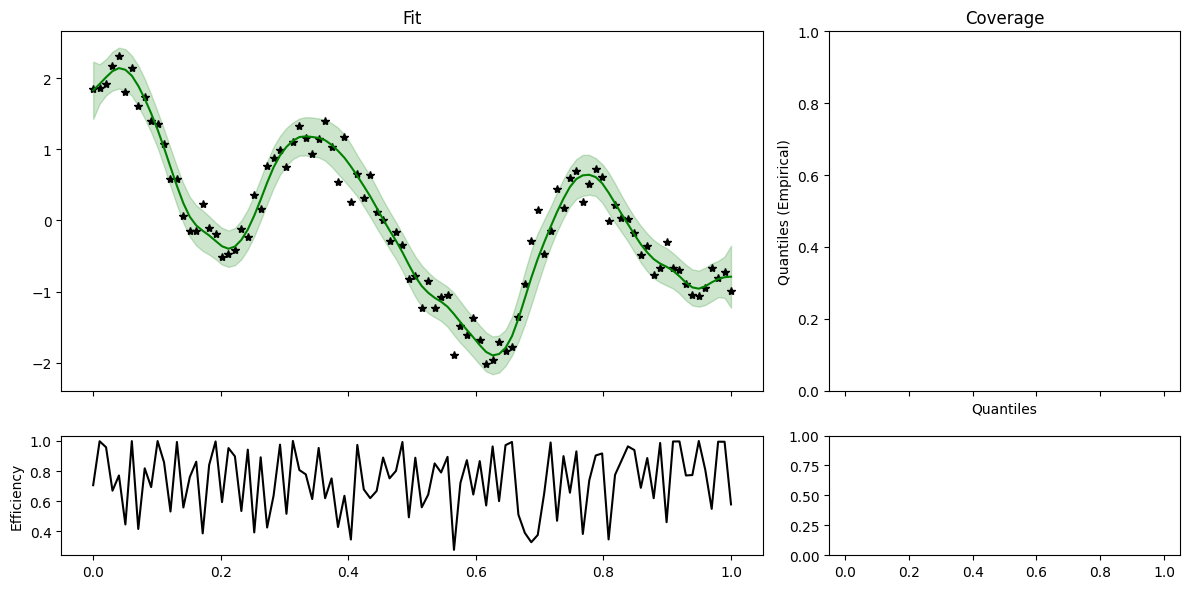

In [33]:
# Create a mosaic layout
fig, axs = plt.subplot_mosaic(
    [
        ["top_left", "quantile"],
        ["bottom_left", "bottom_right"]
    ],
    figsize=(12, 6),
    sharex=True,
    gridspec_kw={"width_ratios": [2, 1], "height_ratios": [3, 1]}
)

# Top Left Plot

axs['top_left'].plot(Xs, Ys, "k*", label="Data")
axs['top_left'].plot(Xs, pred_strcgp, 'g-', label="ST-RCGP")
axs['top_left'].fill_between(Xs, pred_strcgp - 3 * std_strcgp, pred_strcgp + 3 * std_strcgp, color='g', alpha=0.2, label='CI (ST-RCGP)')
axs['top_left'].set_title("Fit")

# Top Right Plot
axs["quantile"].set_title("Coverage")
axs["quantile"].set_xlabel("Quantiles")
axs["quantile"].set_ylabel("Quantiles (Empirical)")

# Bottom Left Plot
axs["bottom_left"].plot(Xs, strcgp_eff, color="black")
axs["bottom_left"].set_ylabel("Efficiency")

# Adjust layout
plt.tight_layout()

# Outliers

In [35]:
strcgp_outliers = fit(Xs=Xs,
                        Ys=Ys_outliers,
                        grid=None,
                        activate_robustness=activate_robustness,
                        weighted_loss=weighted_loss,
                        c=c,
                        c_fixed=c_fixed,
                        lr=0.2,
                        n_steps=60,
                        verbose=verbose,
                        )

with tc.no_grad():   
    pred_strcgp_outliers, std_strcgp_outliers, energies_outliers, Ws_outliers = strcgp_outliers.forward()
    pred_strcgp_outliers = pred_strcgp_outliers.squeeze().numpy()
    std_strcgp_outliers = std_strcgp_outliers.squeeze().numpy()
    Ws_outliers = Ws_outliers[1:-1].squeeze().numpy()
    strcgp_outliers_eff = Ws_outliers / strcgp_outliers.beta.clone().detach()

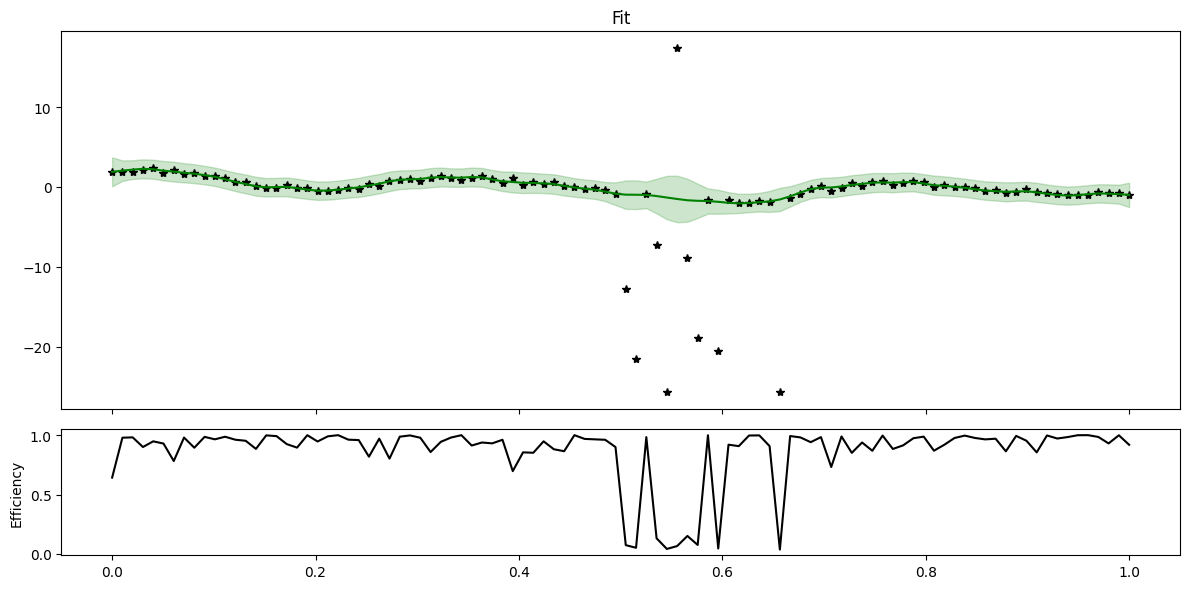

In [ ]:
# Create a mosaic layout
fig, axs = plt.subplot_mosaic(
    [
        ["top"],
        ["bottom"]
    ],
    figsize=(12, 6),
    sharex=True,
    gridspec_kw={ "height_ratios": [3, 1]}
)

# Top Left Plot
axs['top'].plot(Xs, Ys_outliers, "k*", label="Data")
axs['top'].plot(Xs, pred_strcgp_outliers, 'g-', label="ST-RCGP")
axs['top'].fill_between(Xs, pred_strcgp_outliers - 3 * std_strcgp_outliers, pred_strcgp_outliers + 3 * std_strcgp_outliers, color='g', alpha=0.2, label='CI (ST-RCGP)')
axs['top'].set_title("Fit")


# Bottom Left Plot
axs["bottom"].plot(Xs, strcgp_outliers_eff, color="black")
axs["bottom"].set_ylabel("Efficiency")

# Adjust layout
plt.tight_layout()